In [1]:
import os
import sys
import yaml
import json
import joblib
import copy
import uuid
import hashlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm import tqdm
from datetime import datetime
from typing import Dict, List, Tuple, Union, Any

In [27]:
from xgboost import XGBClassifier
from sklearn.base import BaseEstimator
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve, roc_auc_score

In [3]:
# =================================================================
# SEL 1: MOUNT DRIVE DAN KONFIGURASI PATH PROYEK
# =================================================================
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Tentukan path ke folder ROOT proyek Anda
project_root = '/content/drive/MyDrive/ColabNotebooks/PacmannAI/Skill100/Machine-Learning-Process/Live-Class/Week-4'

# 3. Tambahkan path root proyek ke sys.path
if project_root not in sys.path:
  sys.path.append(project_root)

# 4. (Opsional) Ubah direktori kerja ke root proyek
os.chdir(project_root)

# 5. Verifikasi direktori kerja saat ini
print(f"Direktori kerja saat ini: {os.getcwd()}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Direktori kerja saat ini: /content/drive/MyDrive/ColabNotebooks/PacmannAI/Skill100/Machine-Learning-Process/Live-Class/Week-4


In [4]:
# =================================================================
# SEL 2: IMPOR MODUL DAN AKSES DATA
# =================================================================

# 1. Impor fungsi dari modul di dalam folder 'src'
from src.helper.config import load_config, config_updater

# 2. Tentukan path ke file data secara relatif dari ROOT proyek
# Path base_dir sesuai config
BASE_DIR = Path("/content/drive/MyDrive/ColabNotebooks/PacmannAI/Skill100/Machine-Learning-Process/Live-Class/Week-3")

# Lokasi file config.yaml
CONFIG_PATH = BASE_DIR / "config" / "config.yaml"

In [5]:
params = load_config(CONFIG_PATH)

params

{'base_dir': PosixPath('/content/drive/MyDrive/ColabNotebooks/PacmannAI/Skill100/Machine-Learning-Process/Live-Class/Week-3'),
 'dataset_dir': PosixPath('/content/drive/MyDrive/ColabNotebooks/PacmannAI/Skill100/Machine-Learning-Process/Live-Class/Week-3/data/raw'),
 'dataset_processed_dir': PosixPath('/content/drive/MyDrive/ColabNotebooks/PacmannAI/Skill100/Machine-Learning-Process/Live-Class/Week-3/data/processed'),
 'datetime_columns': ['tanggal'],
 'int32_columns': ['pm10', 'pm25', 'so2', 'co', 'o3', 'no2', 'max'],
 'label': 'categori',
 'label_categories': ['BAIK', 'SEDANG', 'TIDAK SEHAT'],
 'label_categories_new': ['BAIK', 'TIDAK BAIK'],
 'missing_value_co': 11,
 'missing_value_no2': 18,
 'missing_value_o3': 29,
 'missing_value_pm10': {'BAIK': 29, 'TIDAK BAIK': 55},
 'missing_value_pm25': {'BAIK': 39, 'TIDAK BAIK': 82},
 'missing_value_so2': 35,
 'object_columns': ['stasiun', 'critical', 'categori'],
 'predictors': ['stasiun', 'pm10', 'pm25', 'so2', 'co', 'o3', 'no2'],
 'range_co'

## 1. Load Dataset

In [6]:
X_rus = joblib.load(f"{params['dataset_processed_dir']}/X_rus.pkl")
y_rus = joblib.load(f"{params['dataset_processed_dir']}/y_rus.pkl")

X_ros = joblib.load(f"{params['dataset_processed_dir']}/X_ros.pkl")
y_ros = joblib.load(f"{params['dataset_processed_dir']}/y_ros.pkl")

X_sm = joblib.load(f"{params['dataset_processed_dir']}/X_sm.pkl")
y_sm = joblib.load(f"{params['dataset_processed_dir']}/y_sm.pkl")

X_valid = joblib.load(f"{params['dataset_processed_dir']}/X_valid_feng.pkl")
y_valid = joblib.load(f"{params['dataset_processed_dir']}/y_valid_feng.pkl")

X_test = joblib.load(f"{params['dataset_processed_dir']}/X_test_feng.pkl")
y_test = joblib.load(f"{params['dataset_processed_dir']}/y_test_feng.pkl")


## 2. Create Log Template

In [7]:
def time_stamp() -> datetime:
    """
    Get the current local date and time.

    Returns:
        datetime.datetime:
            The current local datetime at the moment of function call.

    Example:
        >>> ts = time_stamp()
        >>> print(ts)
        2025-09-09 18:42:13.123456
    """
    return datetime.now()

In [8]:
def create_log_template() -> Dict[str, List[Union[str, float, dict, datetime]]]:
    """
    Create a template dictionary for experiment or model training logs.

    Each key maps to a list, where every list entry corresponds to one
    training run / experiment.

    Returns:
        Dict[str, List[...]]:
            A dictionary with the following keys and expected list element types:

            - "model_name": List[str]
                Model names (e.g., "RandomForestClassifier", "LogisticRegression").

            - "model_uid": List[str]
                Unique identifier per model run (e.g., UUID, hash, or timestamp string).

            - "training_time": List[float]
                Training duration per run (unit: seconds or minutes).

            - "training_date": List[datetime.datetime | str]
                Date and time when training occurred. Can be stored as a datetime
                object or ISO-format string.

            - "performance": List[dict]
                Dictionary of performance metrics per run.
                Example: {"accuracy": 0.92, "precision": 0.90, "recall": 0.88}

            - "f1_score_avg": List[float]
                Average F1-score per run (useful for classification tasks).

            - "data_configurations": List[dict]
                Dictionary describing dataset or preprocessing settings.
                Example:
                    {
                        "train_size": 0.8,
                        "validation_size": 0.2,
                        "scaler": "StandardScaler",
                        "imputer": "SimpleImputer(strategy='median')"
                    }

    Example:
        >>> logs = create_log_template()
        >>> logs["model_name"].append("RandomForestClassifier")
        >>> logs["model_uid"].append("rf_20250909_001")
        >>> logs["training_time"].append(32.57)
        >>> logs["training_date"].append("2025-09-09 19:00:23")
        >>> logs["performance"].append({"accuracy": 0.92, "f1_score": 0.89})
        >>> logs["f1_score_avg"].append(0.89)
        >>> logs["data_configurations"].append({
        ...     "train_size": 0.8,
        ...     "validation_size": 0.2,
        ...     "scaler": "StandardScaler"
        ... })
    """
    logger = {
        "model_name": [],
        "model_uid": [],
        "training_time": [],
        "training_date": [],
        "performance": [],
        "f1_score_avg": [],
        "data_configurations": []
    }
    return logger

In [15]:
def training_log_updater(current_log: dict, log_path: str) -> list[dict]:
    """
    Update a persistent training log file with a new log entry.

    This function:
      1. Loads an existing training log from disk (JSON file).
      2. If the file does not exist or is empty/invalid JSON, initializes it as an empty list.
      3. Appends the new log (`current_log`) to the list.
      4. Writes the updated log list back to disk.
      5. Returns the updated log list.

    Args:
        current_log (dict):
            Dictionary representing the current run's training log.
            Example:
                {
                    "model_name": "RandomForestClassifier",
                    "training_time": 32.57,
                    "performance": {"accuracy": 0.92, "f1_score": 0.89},
                    "training_date": "2025-09-09 19:00:23",
                    ...
                }
        log_path (str):
            Path to the JSON file where logs are stored.

    Returns:
        list[dict]:
            Updated list of all training logs (including the newly appended one).

    Raises:
        json.JSONDecodeError:
            If the log file exists but is not valid JSON.

    Notes:
        - If `log_path` does not exist, the function creates a new JSON file
          containing an empty list (`[]`) before appending the new log.
        - The function overwrites the file with the updated log list.
        - Each call appends exactly one `current_log`.

    Example:
        >>> new_log = {
        ...     "model_name": "LogisticRegression",
        ...     "model_uid": "lr_20250909_002",
        ...     "training_time": 12.14,
        ...     "training_date": "2025-09-09 19:15:42",
        ...     "performance": {"accuracy": 0.88, "f1_score": 0.85},
        ...     "f1_score_avg": 0.85,
        ...     "data_configurations": {"train_size": 0.7, "validation_size": 0.3}
        ... }
        >>> updated_logs = training_log_updater(new_log, "training_log.json")
        >>> len(updated_logs)
        5   # (assuming there were 4 previous logs)
    """
    # Buat salinan dari log saat ini agar tidak mempengaruhi data log aslinya
    current_log = current_log.copy()

    # Mencoba untuk membuka file training log yang ada pada disk
    try:
        with open(log_path, "r") as file:
            last_log = json.load(file)

    # Kondisi jika ternyata tidak ada file training log yang dimaksud atau isinya tidak valid JSON
    except (FileNotFoundError, json.JSONDecodeError) as e:
        # Jika tidak ada atau isinya tidak valid, maka buat file training log baru dengan list kosong
        with open(log_path, "w") as file:
            file.write("[]")

        # Lalu load ke program (yang sekarang dipastikan berisi list kosong)
        with open(log_path, "r") as file:
            last_log = json.load(file)

    # Tambahkan log baru (yang bersumber dari argument method) ke log yang telah ada (yang bersumber dari file pada disk)
    last_log.append(current_log)

    # Buka file training log pada disk lalu timpa dengan training log baru yang telah ada pembaharuan
    with open(log_path, "w") as file:
        json.dump(last_log, file)

    # Kembalikan training log terbaru
    return last_log

## 2. Training and Evaluation

### 2.1. Create Model Object

In [10]:
xgb_baseline = XGBClassifier()
lgr_baseline = LogisticRegression()
dct_baseline = DecisionTreeClassifier()
knn_baseline = KNeighborsClassifier()
rfc_baseline = RandomForestClassifier()

In [11]:
list_of_model = {
    "undersampling" : [
        { "model_name": lgr_baseline.__class__.__name__, "model_object": lgr_baseline, "model_uid": ""},
        { "model_name": dct_baseline.__class__.__name__, "model_object": dct_baseline, "model_uid": ""},
        { "model_name": rfc_baseline.__class__.__name__, "model_object": rfc_baseline, "model_uid": ""},
        { "model_name": knn_baseline.__class__.__name__, "model_object": knn_baseline, "model_uid": ""},
        { "model_name": xgb_baseline.__class__.__name__, "model_object": xgb_baseline, "model_uid": ""}
        ],
    "oversampling" : [
        { "model_name": lgr_baseline.__class__.__name__, "model_object": lgr_baseline, "model_uid": ""},
        { "model_name": dct_baseline.__class__.__name__, "model_object": dct_baseline, "model_uid": ""},
        { "model_name": rfc_baseline.__class__.__name__, "model_object": rfc_baseline, "model_uid": ""},
        { "model_name": knn_baseline.__class__.__name__, "model_object": knn_baseline, "model_uid": ""},
        { "model_name": xgb_baseline.__class__.__name__, "model_object": xgb_baseline, "model_uid": ""}
        ],
    "smote" : [
        { "model_name": lgr_baseline.__class__.__name__, "model_object": lgr_baseline, "model_uid": ""},
        { "model_name": dct_baseline.__class__.__name__, "model_object": dct_baseline, "model_uid": ""},
        { "model_name": rfc_baseline.__class__.__name__, "model_object": rfc_baseline, "model_uid": ""},
        { "model_name": knn_baseline.__class__.__name__, "model_object": knn_baseline, "model_uid": ""},
        { "model_name": xgb_baseline.__class__.__name__, "model_object": xgb_baseline, "model_uid": ""}
        ],
    }

### 2.2. Training Model

In [12]:
def train_eval_model(
    list_of_model: List[Dict[str, Any]],
    prefix_model_name: str,
    x_train: Any,
    y_train: Any,
    data_configuration_name: str,
    x_valid: Any,
    y_valid: Any,
    log_path: str
) -> Tuple[List[Dict[str, Any]], List[Dict[str, Any]]]:
    """
    Train and evaluate a list of models, record logs, and update persistent training history.

    Args:
        list_of_model (List[Dict[str, Any]]):
            List of models with metadata. Each dict must contain:
              - "model_name" (str): model label.
              - "model_object" (estimator): sklearn-compatible model with `.fit()` and `.predict()`.
        prefix_model_name (str):
            Prefix string added to each model name (e.g., experiment ID).
        x_train (array-like | pandas.DataFrame):
            Training features.
        y_train (array-like | pandas.Series):
            Training target labels.
        data_configuration_name (str):
            Identifier or config name describing data setup.
        x_valid (array-like | pandas.DataFrame):
            Validation features.
        y_valid (array-like | pandas.Series):
            Validation target labels.
        log_path (str):
            Path to JSON file where logs are persisted.

    Returns:
        Tuple[List[Dict[str, Any]], List[Dict[str, Any]]]:
            - training_log: updated list of all training logs (loaded from `log_path`).
            - list_of_model: updated list of models, each enriched with a "model_uid" key.

    Notes:
        - Each run gets a unique model ID (`model_uid`) generated via `uuid4().hex`.
        - Training time is measured in seconds.
        - Macro-average F1-score is extracted separately and logged.
        - Evaluation uses `classification_report` (scikit-learn) with `output_dict=True`.

    Example:
        >>> models = [
        ...     {"model_name": "LogReg", "model_object": LogisticRegression()},
        ...     {"model_name": "DecisionTree", "model_object": DecisionTreeClassifier()}
        ... ]
        >>> training_log, trained_models = train_eval_model(
        ...     list_of_model=models,
        ...     prefix_model_name="exp1",
        ...     x_train=X_train, y_train=y_train,
        ...     data_configuration_name="dataset_v1",
        ...     x_valid=X_val, y_valid=y_val,
        ...     log_path="training_log.json"
        ... )
        >>> training_log[-1]["model_name"]
        'exp1-DecisionTree'
        >>> trained_models[0]["model_uid"]  # unique ID
        '3c0a64d68a0a4565a8d7d2c8f354b2df'
    """
    # Buat salinan dari list_of_model agar data aslinya tidak berubah
    list_of_model = copy.deepcopy(list_of_model)

    # Buat template log
    logger = create_log_template()

    # Loop model
    for model in tqdm(list_of_model):
        model_name = prefix_model_name + "-" + model["model_name"]

        # Training
        start_time = time_stamp()
        model["model_object"].fit(x_train, y_train)
        finished_time = time_stamp()

        # Hitung waktu training
        elapsed_time = (finished_time - start_time).total_seconds()

        # Evaluasi
        y_pred = model["model_object"].predict(x_valid)
        performance = classification_report(y_valid, y_pred, output_dict=True)

        # Generate unique ID pakai UUID4
        chiper_id = uuid.uuid4().hex
        model["model_uid"] = chiper_id

        # Simpan log
        logger["model_name"].append(model_name)
        logger["model_uid"].append(chiper_id)
        logger["training_time"].append(elapsed_time)
        logger["training_date"].append(str(start_time))
        logger["performance"].append(performance)
        logger["f1_score_avg"].append(performance["macro avg"]["f1-score"])
        logger["data_configurations"].append(data_configuration_name)

    # Update log ke file JSON
    training_log = training_log_updater(logger, log_path)

    return training_log, list_of_model


In [16]:
training_log, list_of_model_rus = train_eval_model(
    list_of_model = list_of_model["undersampling"],
    prefix_model_name = "baseline_model",
    x_train = X_rus,
    y_train = y_rus,
    data_configuration_name = "undersampling",
    x_valid = X_valid,
    y_valid= y_valid,
    log_path = "log/training_log.json"
)

  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 5/5 [00:00<00:00,  8.15it/s]


In [17]:
# Timpa data model pada bagian undersampling dengan data model terbaru yang telah dilakukan training
list_of_model["undersampling"] = copy.deepcopy(list_of_model_rus)

In [18]:
list_of_model["undersampling"]

[{'model_name': 'LogisticRegression',
  'model_object': LogisticRegression(),
  'model_uid': '8408934d900d439ebd70505c1135c5c1'},
 {'model_name': 'DecisionTreeClassifier',
  'model_object': DecisionTreeClassifier(),
  'model_uid': '00c03e291d9a4d9d8f77c2cbf9d98648'},
 {'model_name': 'RandomForestClassifier',
  'model_object': RandomForestClassifier(),
  'model_uid': '23b9d90f9ee0447fa230df41a96d6f74'},
 {'model_name': 'KNeighborsClassifier',
  'model_object': KNeighborsClassifier(),
  'model_uid': 'e58758a6475647cfa43d29a274bbeed4'},
 {'model_name': 'XGBClassifier',
  'model_object': XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                feature_weights=None, gamma=None, grow_policy=None,
                importance_type=None, interaction_constra

#### 2.2.2. Baseline Model Oversampling

In [19]:
training_log, list_of_model_ros = train_eval_model(
    list_of_model = list_of_model["oversampling"],
    prefix_model_name = "baseline_model",
    x_train = X_ros,
    y_train = y_ros,
    data_configuration_name = "oversampling",
    x_valid = X_valid,
    y_valid= y_valid,
    log_path = "log/training_log.json"
)

  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


In [20]:
list_of_model["oversampling"] = copy.deepcopy(list_of_model_ros)

In [21]:
list_of_model["oversampling"]

[{'model_name': 'LogisticRegression',
  'model_object': LogisticRegression(),
  'model_uid': '6230c98b0d63496f8c2ed30b349b884a'},
 {'model_name': 'DecisionTreeClassifier',
  'model_object': DecisionTreeClassifier(),
  'model_uid': '1aa150d66a574b15a090194c3b8ce181'},
 {'model_name': 'RandomForestClassifier',
  'model_object': RandomForestClassifier(),
  'model_uid': '4516e62d844d4d2e80fc64dd3d4e4963'},
 {'model_name': 'KNeighborsClassifier',
  'model_object': KNeighborsClassifier(),
  'model_uid': 'e3a72a30ef5b4df8a9aa3a11c2c596bc'},
 {'model_name': 'XGBClassifier',
  'model_object': XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                feature_weights=None, gamma=None, grow_policy=None,
                importance_type=None, interaction_constra

#### 2.2.3. Baseline Model SMOTE

In [22]:
training_log, list_of_model_sm = train_eval_model(
    list_of_model = list_of_model["smote"],
    prefix_model_name = "baseline_model",
    x_train = X_sm,
    y_train= y_sm,
    data_configuration_name = "smote",
    x_valid = X_valid,
    y_valid= y_valid,
    log_path = "log/training_log.json"
)

  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 5/5 [00:00<00:00,  6.86it/s]


In [23]:
list_of_model["smote"] = copy.deepcopy(list_of_model_sm)

#### 2.3.4. Best Performance

In [24]:
# Fungsi untuk membuat data training log yang berupa dictionary menjadi dataframe agar dapat diurutkan dengan mudah serta gampang dilihat
def training_log_to_df(training_log: List[Dict[str, Any]]) -> pd.DataFrame:
    """
    Convert a list of training logs (dictionaries) into a consolidated DataFrame.

    This function takes a list of dictionaries (each representing a training log
    or experiment record), converts them into DataFrames, concatenates them once
    for efficiency, and then sorts the results by F1-score (descending) and
    training time (ascending).

    Args:
        training_log (List[Dict[str, Any]]):
            List of training log dictionaries. Each dictionary should follow the
            schema produced by `train_eval_model` / `create_log_template`, with keys:
                - "model_name" (List[str])
                - "model_uid" (List[str])
                - "training_time" (List[float])
                - "training_date" (List[str] or List[datetime])
                - "performance" (List[dict])
                - "f1_score_avg" (List[float])
                - "data_configurations" (List[dict] or List[str])

    Returns:
        pd.DataFrame:
            A consolidated DataFrame containing all log entries, sorted by:
            - `f1_score_avg` in descending order (higher is better),
            - then `training_time` in ascending order (faster models ranked first).
            The index is reset for readability.

    Notes:
        - More efficient than concatenating inside a loop (concats once at the end).
        - The `performance` column may contain nested dictionaries if saved directly
          from `classification_report`.
        - Can be exported directly to CSV/Excel for reporting.

    Example:
        >>> logs = [
        ...     {
        ...         "model_name": ["LogReg"],
        ...         "model_uid": ["uuid1"],
        ...         "training_time": [12.3],
        ...         "training_date": ["2025-09-09 19:00:23"],
        ...         "performance": [{"accuracy": 0.88}],
        ...         "f1_score_avg": [0.85],
        ...         "data_configurations": ["config_v1"]
        ...     },
        ...     {
        ...         "model_name": ["DecisionTree"],
        ...         "model_uid": ["uuid2"],
        ...         "training_time": [8.9],
        ...         "training_date": ["2025-09-09 19:05:12"],
        ...         "performance": [{"accuracy": 0.92}],
        ...         "f1_score_avg": [0.89],
        ...         "data_configurations": ["config_v2"]
        ...     }
        ... ]
        >>> df = training_log_to_df(logs)
        >>> df[["model_name", "f1_score_avg", "training_time"]]
          model_name  f1_score_avg  training_time
        0  DecisionTree         0.89            8.9
        1        LogReg         0.85           12.3
    """
    # Kumpulkan semua log jadi DataFrame, lalu concat sekali
    frames = [pd.DataFrame(log) for log in tqdm(training_log)]
    training_res = pd.concat(frames, ignore_index=True)

    # Urutkan berdasarkan F1 score (descending) lalu training time (ascending)
    training_res.sort_values(
        ["f1_score_avg", "training_time"],
        ascending=[False, True],
        inplace=True
    )

    # Reset index
    training_res.reset_index(drop=True, inplace=True)

    return training_res

In [25]:
training_res = training_log_to_df(training_log)

100%|██████████| 3/3 [00:00<00:00, 999.91it/s]


In [26]:
training_res

,model_name,model_uid,training_time,training_date,performance,f1_score_avg,data_configurations
0,baseline_model-DecisionTreeClassifier,7e0f70eeda8b41b1b139dc90f92da313,0.010834,2025-09-12 11:49:26.146019,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,smote
1,baseline_model-DecisionTreeClassifier,1aa150d66a574b15a090194c3b8ce181,0.037613,2025-09-12 11:48:16.438253,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,oversampling
2,baseline_model-XGBClassifier,48df65cefec24c3786acaa6716b44094,0.042553,2025-09-12 11:49:26.760067,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,smote
3,baseline_model-RandomForestClassifier,0a944ac52f1948d387d8be5586fdbe4a,0.530180,2025-09-12 11:49:26.172350,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,smote
4,baseline_model-RandomForestClassifier,4516e62d844d4d2e80fc64dd3d4e4963,0.694750,2025-09-12 11:48:16.515749,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,oversampling
5,baseline_model-XGBClassifier,28bda2de25464a78ae9307429ea76574,0.848928,2025-09-12 11:48:17.347542,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,oversampling
6,baseline_model-DecisionTreeClassifier,00c03e291d9a4d9d8f77c2cbf9d98648,0.004256,2025-09-12 11:46:11.015008,"{'0': {'precision': 0.9333333333333333, 'recal...",0.980701,undersampling
7,baseline_model-KNeighborsClassifier,e3a72a30ef5b4df8a9aa3a11c2c596bc,0.009322,2025-09-12 11:48:17.281715,"{'0': {'precision': 0.9032258064516129, 'recal...",0.971483,oversampling
8,baseline_model-KNeighborsClassifier,47465c1514ac453281c4fda7bcf83381,0.009345,2025-09-12 11:49:26.734575,"{'0': {'precision': 0.9032258064516129, 'recal...",0.971483,smote
9,baseline_model-XGBClassifier,8b56930476df4a5cb54082ffeaf8d121,0.076323,2025-09-12 11:46:11.435238,"{'0': {'precision': 0.8235294117647058, 'recal...",0.945389,undersampling


In [28]:
# Fungsi untuk mendapatkan model yang terbaik berdasarkan training log yang telah kita buat
def get_best_model(
    training_log_df: pd.DataFrame,
    list_of_model: Dict[str, List[Dict[str, Any]]]
) -> BaseEstimator:
    """
    Retrieve the best trained model object based on the training log.

    The best model is chosen as the one with the highest `f1_score_avg`
    and, in case of ties, the smallest `training_time` (ascending).
    Its unique ID (`model_uid`) is then matched against entries in
    `list_of_model` to return the corresponding fitted estimator.

    Args:
        training_log_df (pandas.DataFrame):
            Consolidated training log DataFrame. Must contain at least the columns:
              - "model_uid" (str): unique identifier per trained model/run.
              - "f1_score_avg" (float): macro-average F1-score.
              - "training_time" (float): training duration in seconds.
        list_of_model (Dict[str, List[Dict[str, Any]]]):
            Dictionary mapping a configuration name (e.g., "undersampling",
            "oversampling", "smote") to a list of model dictionaries.
            Each model dictionary must contain:
              - "model_uid" (str): unique identifier that matches training_log_df.
              - "model_object" (sklearn.base.BaseEstimator): the trained estimator.

    Returns:
        sklearn.base.BaseEstimator:
            The best model object corresponding to the top-ranked log entry.

    Raises:
        RuntimeError:
            If the best model's `model_uid` cannot be found in `list_of_model`.

    Example:
        >>> best_model = get_best_model(training_log_df, list_of_model)
        >>> y_pred = best_model.predict(X_test)
    """
    # Buat variable untuk menyimpan model terbaik
    model_object = None

    # Urutkan training log berdasarkan F1 score dan training time serta ambil peringkat pertamanya
    # Dari training log kita bisa mendapatkan unik ID yang nantinya akan dicocokkan pada list of model
    best_model_info = training_log_df.sort_values(
        ["f1_score_avg", "training_time"],
        ascending=[False, True]
    ).iloc[0]

    # Perulangan untuk mencari model dengan unik ID yang telah kita dapatkan sebelumnya (unik ID yang terdapat pada variable best_model_info)
    # Kita tahu bahwa list_of_model terbagi menjadi 3, yaitu undersampling; oversampling; dan smote
    # Perulangan yang pertama ini untuk mengakses masing-masing dari ketiga tipe tersebut
    for configuration_data in list_of_model:

        # Perulangan yang kedua ini untuk mengakses model data (Logistic Regression, Decision Tree, dll) pada tipe data tertentu (undersampling, oversampling, dll)
        for model_data in list_of_model[configuration_data]:

            # Untuk tiap model data (Logistic Regression, Decision Tree, dll), cek unik IDnya. Apakah sama atau tidak
            # Jika tidak sama, ulangi lagi pengecekan hingga mendapatkan unik ID yang sama
            # Jika sama, maka ambil data modelnya (terdapat pada key "model_object") kemudian simpan pada variable model_object yang telah kita buat pada awal method ini
            if model_data["model_uid"] == best_model_info["model_uid"]:
                model_object = model_data["model_object"]

                # Jika telah menemukan unik IDnya, maka hentikan pencarian
                break

    # Kondisi dimana unik ID dari model terbaik tidak ditemukan, hal ini mungkin terjadi jika performa model pada sesi training saat ini tidak lebih baik dari performa model pada sesi training sebelumnya
    if model_object == None:

        # Jika tidak ada model terbaik, raise error
        raise RuntimeError("The best model not found in your list of model.")

    # Kembalikan model terbaik
    return model_object


In [29]:
model = get_best_model(training_res, list_of_model)

In [30]:
model

DecisionTreeClassifier()

In [31]:
joblib.dump(model, "models/model.pkl")

['models/model.pkl']

#### 2.2.5. Hyperparameter Tuning

In [32]:
# Pada bagian ini kita membuat 1 model baru (bebas mau menggunakan model apa) yang diperuntukkan untuk mencoba training model dengan tuning

In [33]:
# Spektrum hyperparameter dari model yang akan kita gunakan
# Sebagai contoh, pada kesempatan kali ini kita akan menggunakan KNN
dist_params_knn = {
    "algorithm" : ["ball_tree", "kd_tree", "brute"],
    "n_neighbors" : [2, 3, 4, 5, 6, 10, 15, 20, 25],
    "leaf_size" : [2, 3, 4, 5, 6, 10, 15, 20, 25],
}

In [34]:
# Untuk training model serta melakukan hyperparameter tuning, digunakanlah GridSearchCV sebagai contoh
knn_enh = GridSearchCV(KNeighborsClassifier(), dist_params_knn, n_jobs = -1, verbose = 420)

In [35]:
# Masukkan object model yang telah kita buat tadi (KNN + GridSearchCV) ke struktur list_of_model yang compatible dengan fungsi training dan logging yang telah kita buat sebelumnya
list_of_model["undersampling"].append({"model_name": knn_enh.__class__.__name__ + "-" + knn_enh.estimator.__class__.__name__, "model_object": copy.deepcopy(knn_enh), "model_uid": ""})
list_of_model["oversampling"].append({"model_name": knn_enh.__class__.__name__ + "-" + knn_enh.estimator.__class__.__name__, "model_object": copy.deepcopy(knn_enh), "model_uid": ""})
list_of_model["smote"].append({"model_name": knn_enh.__class__.__name__ + "-" + knn_enh.estimator.__class__.__name__, "model_object": copy.deepcopy(knn_enh), "model_uid": ""})

In [36]:
# Lakukan training, namun untuk contoh kali ini hanya pada bagian undersampling
# Perlu diperhatikan bahwa kita hanya ingin training model KNN + Hyperparams tuning, sehingga kita hanya memilih object model terakhir dengan menggunakan slicing [-1]
# Dan karena hanya bagian undersampling dan object terakhir saja yang dislice, maka hasil slicenya adalah dictionary
# Fungsi train_eval_model tidak compatible dengan dictionary dan hanya compatible dengan list of model (list of undersampling, list of oversampling, dll)
# Namun jika kita menggunakan list of undersampling saja (tanpa dislide dengan -1), maka semua model akan ditraining ulang, pada case ini kita tidak mau seperti itu, kita hanya ingin training model paling akhir (KNN + GridSearchCV)
# Maka dari itu object model hasil slice tadi kita buat menjadi list dengan menggunakan kurung siku

training_log, list_of_model_rus_hyp = train_eval_model(
    list_of_model = [list_of_model["undersampling"][-1]],
    prefix_model_name = "hyperparams",
    x_train = X_rus,
    y_train = y_rus,
    data_configuration_name = "undersampling",
    x_valid = X_valid,
    y_valid= y_valid,
    log_path = "log/training_log.json"
)

  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


100%|██████████| 1/1 [00:10<00:00, 10.79s/it]


In [37]:
# Update model data pada object list_of_model karena jika tidak diupdate maka model yang terdapat pada object tersebut adalah model yang belum ditrain
list_of_model["undersampling"][-1] = copy.deepcopy(list_of_model_rus_hyp[0])

In [38]:
list_of_model["undersampling"][-1]

{'model_name': 'GridSearchCV-KNeighborsClassifier',
 'model_object': GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
              param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                          'leaf_size': [2, 3, 4, 5, 6, 10, 15, 20, 25],
                          'n_neighbors': [2, 3, 4, 5, 6, 10, 15, 20, 25]},
              verbose=420),
 'model_uid': '876d8c976dbe4f2d94ebc26add7923d1'}

In [39]:
training_log_to_df(training_log)

100%|██████████| 4/4 [00:00<00:00, 814.31it/s]


,model_name,model_uid,training_time,training_date,performance,f1_score_avg,data_configurations
0,baseline_model-DecisionTreeClassifier,7e0f70eeda8b41b1b139dc90f92da313,0.010834,2025-09-12 11:49:26.146019,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,smote
1,baseline_model-DecisionTreeClassifier,1aa150d66a574b15a090194c3b8ce181,0.037613,2025-09-12 11:48:16.438253,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,oversampling
2,baseline_model-XGBClassifier,48df65cefec24c3786acaa6716b44094,0.042553,2025-09-12 11:49:26.760067,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,smote
3,baseline_model-RandomForestClassifier,0a944ac52f1948d387d8be5586fdbe4a,0.530180,2025-09-12 11:49:26.172350,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,smote
4,baseline_model-RandomForestClassifier,4516e62d844d4d2e80fc64dd3d4e4963,0.694750,2025-09-12 11:48:16.515749,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,oversampling
5,baseline_model-XGBClassifier,28bda2de25464a78ae9307429ea76574,0.848928,2025-09-12 11:48:17.347542,"{'0': {'precision': 1.0, 'recall': 1.0, 'f1-sc...",1.000000,oversampling
6,baseline_model-DecisionTreeClassifier,00c03e291d9a4d9d8f77c2cbf9d98648,0.004256,2025-09-12 11:46:11.015008,"{'0': {'precision': 0.9333333333333333, 'recal...",0.980701,undersampling
7,baseline_model-KNeighborsClassifier,e3a72a30ef5b4df8a9aa3a11c2c596bc,0.009322,2025-09-12 11:48:17.281715,"{'0': {'precision': 0.9032258064516129, 'recal...",0.971483,oversampling
8,baseline_model-KNeighborsClassifier,47465c1514ac453281c4fda7bcf83381,0.009345,2025-09-12 11:49:26.734575,"{'0': {'precision': 0.9032258064516129, 'recal...",0.971483,smote
9,baseline_model-XGBClassifier,8b56930476df4a5cb54082ffeaf8d121,0.076323,2025-09-12 11:46:11.435238,"{'0': {'precision': 0.8235294117647058, 'recal...",0.945389,undersampling


#### 2.2.6. Take a Look at Confusion Matrix

In [41]:
y_pred = model.predict(X_valid)

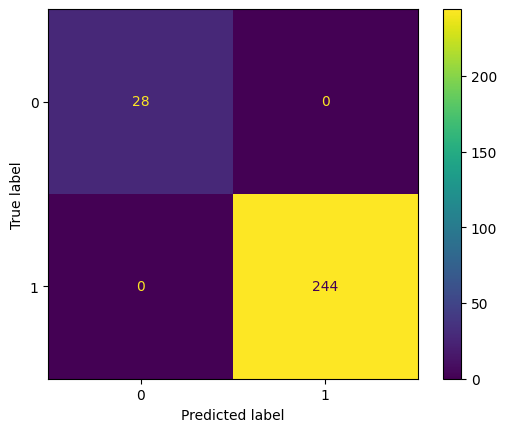

In [42]:
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred)